# Group Delay Integration
After having the group delay (GD) extracted, the spectral phase can be finally calculated. This can be done by a simple discrete integration.
However, there is another more accurate way to reconstruct the spectral phase out of the extracted GD based on the method reported by <a href="https://opg.optica.org/josa/abstract.cfm?uri=josa-72-1-156">Takeda *et. al.*</a>.
Taking the fact that actually the finite difference of the spectral phase ($\color{green}{\Phi(\omega)- \Phi(\omega - \Omega)}$) got extracted out ot the 2DSI-map, a recursive formula can be used to calculate the exact spectral phase at a spacing dependent on the shear frequency.

### Theory: Recursive Calculation of the Spectral Phase
This is possible through transforming the extracted finite difference of the spectral phase: $\color{green}{\Delta\Phi(\omega) = \Phi(\omega)- \Phi(\omega - \Omega)}$ and taking a discrete frequency axis where $\omega \rightarrow \omega_i$, $\omega + \Omega \rightarrow \omega_{i+1}$ and $\omega - \Omega \rightarrow \omega_{i-1}$ with $i$ being integers. Furthermore the spectral phase at the center frequency $\omega_0$ is $\Phi(\omega_0) = 0$.




<table style="width: 80%;">
  <tr>
    <td> <center> For $i >$ 0 </center> </td>
    <td> <center> For $i <$ 0 </center> </td>
  </tr>

  <tr>
    <td> <center> $\Phi(\omega_i) = \Delta\Phi(\omega_i) + \Phi(\omega_{i-1})$ </center> </td>
    <td> <center> $\Phi(\omega_{i-1}) = -\Delta\Phi(\omega_i) + \Phi(\omega_i)$ </center> </td>
  </tr>

 
  <tr>
    <td colspan="2"> <center> Example: </center> </td>
  </tr>

  <tr>
    <td> <center> $\Phi(\omega_1) = \Delta\Phi(\omega_1) + \Phi(\omega_{0})$ </center> </td>
    <td> <center> $\Phi(\omega_{-1}) = -\Delta\Phi(\omega_0) + \Phi(\omega_0)$ </center> </td>
  </tr>
     
  <tr>
    <td> <center> $\Phi(\omega_2) = \Delta\Phi(\omega_2) + \Phi(\omega_{1})$ </center> </td>
    <td> <center> $\Phi(\omega_{-2}) = -\Delta\Phi(\omega_{-1}) + \Phi(\omega_{-1})$</center> </td>
  </tr>
  
  <tr>
    <td> <center> $\Phi(\omega_3) = \Delta\Phi(\omega_3) + \Phi(\omega_{2})$ </center> </td>
    <td> <center> $\Phi(\omega_{-3}) = -\Delta\Phi(\omega_{-2}) + \Phi(\omega_{-2})$</center> </td>
  </tr>
      
  <tr>
    <td> <center> $\vdots$ </center> </td>
    <td> <center> $\vdots$ </center> </td>
  </tr>

</table>

It can be seen, that the exact spectral phase points can be calculated through this recursive cummulative sum. A discussion on why this way of calculating the spectral phase is recommended rather than a standard numerical integration of the GD, can be found in chapter 7B of <a  ref="https://opg.optica.org/josab/abstract.cfm?uri=josab-27-6-1165">Birge *et. al.*</a>. (Furthermore, note that in this Notebook there is no need to use frequency-band filters such as anti-aliasing filters in contrast to real 2DSI measurements.)

### Import of data and packages

In [1]:
#Import of packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import sys
from scipy.interpolate import interp1d

#Import of the dataframe
df_GDOmega = pd.read_csv("Data/GDOmega.csv", index_col = 0)

#Create numpy arrays out of the imported data
#Pulse
f_2DSI = df_GDOmega.loc[:, 'f (Hz)'].to_numpy()
GDOmega = df_GDOmega.loc[:, 'GDOmega (rad)'].to_numpy()           #frequency axis pulse

f_shear = df_GDOmega.loc[:, 'shear (Hz)'].to_numpy() #shear of the 2DSI-map
f_shear = f_shear[0]                                 #only one value is needed

f_center_SFG = df_GDOmega.loc[:, 'f_c_SFG (Hz)'].to_numpy()
f_center_SFG = f_center_SFG[0]

### Preparation and interpolation onto the new frequency axis
Creation of the discrete frequency axis containing the SFG center frequency:

In [2]:
#Discrete frequency axis from the center frequency to the beginning of the f_2DSI frequency axis in steps of the shear
f_discrete_1 = np.flip(np.arange(f_center_SFG, f_2DSI[0], -f_shear)) 

#Discrete frequency axis from the center freqency to the end of the f_2DSI frequency axis in steps of the shear 
f_discrete_2 = np.arange(f_center_SFG, f_2DSI[-1], f_shear) 

#Concatenation of the two sides:
f_discrete = np.concatenate((f_discrete_1[0:-1], f_discrete_2))

#Index of the center
center_index = len(f_discrete_1) - 1

In [3]:
#Interpolation of the 2DSI-map's result:
interpol = interp1d(f_2DSI, GDOmega, 'zero')
#GDOmega_discrete = interpol(f_discrete) + 0.03

GDOmega_discrete = interpol(f_discrete)

In [4]:
phase_discrete = np.zeros(np.shape(GDOmega_discrete)) #Creation of the empty vector
        
#Recursive cummulation for i>1 (starting from the center_index)
for i in range(center_index + 1, len(GDOmega_discrete)):
    phase_discrete[i] = GDOmega_discrete[i] + phase_discrete[i-1]

#Recursive cummulation for i<1 (starting from the center_index)
for i in range(center_index-1, -1, -1):
    phase_discrete[i] = -GDOmega_discrete[i+1] + phase_discrete[i+1]

### Plot of the result:

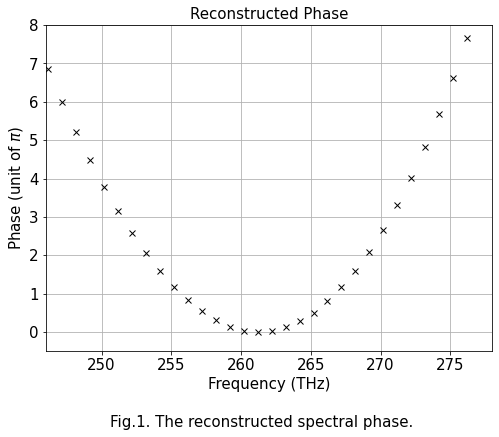

In [5]:
figPhase = plt.figure(figsize = (8, 6))
ax_phase = figPhase.add_subplot(111)
#Intensity over frequency
ax_phase.plot(f_discrete / 10**12, phase_discrete / np.pi, 'kx')                                     #Plot spectrum

#Title and labels
ax_phase.set_title("Reconstructed Phase", fontsize = 15)
ax_phase.set_xlabel("Frequency (THz)", fontsize = 15)
ax_phase.set_ylabel("Phase (unit of $\pi$)", fontsize = 15)
ax_phase.tick_params(axis = 'both', which = 'major', labelsize = 15)


#Figure Caption
figurecounter = 1                                                            #Counter for the figure number
figurecaption = ('Fig.' + str(figurecounter) + '. ' \
                 'The reconstructed spectral phase.')

figPhase.text(.5, -0.05, figurecaption, ha = 'center', fontsize = 15)

#Grids
ax_phase.grid()                                                        #The grid of the phase-value ticks is wanted


#Limits
ax_phase.set_xlim((246, 278))
ax_phase.set_ylim((-0.5, 8))
plt.show()

In [6]:
#Comparision with real results
df_pulse = pd.read_csv("Data/pulse.csv", index_col = 0)
f = df_pulse.loc[:, 'f (Hz)'].to_numpy()           #frequency axis pulse
i_f = df_pulse.loc[:, 'spec (norm.)'].to_numpy()   #spectrum (intensity) pulse
phase = df_pulse.loc[:, 'phase (rad)'].to_numpy()  #phase of the pulse

interpol = interp1d(f + f_center_SFG/2, phase, 'zero')
phase_real = interpol(f_discrete)

phase_inter_discrete = interp1d(f_discrete, phase_discrete, fill_value = "extrapolate")
poly_coefficient = np.polyfit(f_2DSI - f_center_SFG, phase_inter_discrete(f_2DSI), 7)
poly_coefficient[-1] = 0 #0th order
poly_coefficient[-2] = 0 #1st order

phase_discrete_poly = np.poly1d(poly_coefficient)(f_discrete - (f_center_SFG))

## Creating a pandas data frame:¶

In [7]:
#Dataframe for the pulse:
data_Phase = {'f_discrete (Hz)': f_discrete, 'phase_discrete (rad)': phase_discrete}        #creation of a dictonary
df_Phase = pd.DataFrame(data = data_Phase)

#Save to csv-file in the Data folder
df_Phase.to_csv('Data/Phase.csv')